# Análisis Descriptivo con Corrección por Inflación
#
Este análisis incluye la corrección por inflación para las variables `revenue` y `budget`
utilizando factores de conversión a dólares constantes de 2023.
#


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)


## 2. Cargar y Preparar Datos del Dataset Final
#


In [6]:
# Cargar el dataset procesado
try:
    df_with_inflation = pd.read_pickle('../../data/processed_data/movies_with_embeddings_filtered_inflation_correction.pkl')
    print(f"✅ Dataset cargado exitosamente: {len(df_with_inflation):,} películas")
except FileNotFoundError:
    print("⚠️  Archivo no encontrado. Verificar ruta del dataset.")
    # En caso de no encontrar el archivo, usar datos de muestra
    df_with_inflation = None

if df_with_inflation is not None:
    print(f"Columnas disponibles: {list(df_with_inflation.columns)}")
    print(f"Período de datos: {df_with_inflation['release_year'].min():.0f} - {df_with_inflation['release_year'].max():.0f}")



✅ Dataset cargado exitosamente: 15,365 películas
Columnas disponibles: ['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date', 'revenue', 'runtime', 'budget', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'tagline', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'cast', 'director', 'director_of_photography', 'writers', 'producers', 'music_composer', 'imdb_rating', 'imdb_votes', 'poster_path', 'all_text_joined', 'embedding', 'release_year', 'release_month', 'inflation_factor', 'budget_real_2023', 'revenue_real_2023']
Período de datos: 1911 - 2026


## 4. Estadísticas Descriptivas Comparativas
#


In [7]:
def descriptive_statistics_comparison(df, nominal_cols, real_cols):
    """
    Genera estadísticas descriptivas comparando valores nominales vs reales
    """
    print("=" * 80)
    print("ESTADÍSTICAS DESCRIPTIVAS: VALORES NOMINALES vs REALES (2023)")
    print("=" * 80)

    stats_comparison = {}

    for nom_col, real_col in zip(nominal_cols, real_cols):
        print(f"\n📊 {nom_col.upper()} - COMPARACIÓN NOMINAL vs REAL")
        print("-" * 60)

        # Estadísticas básicas
        nom_stats = df[nom_col].describe()
        real_stats = df[real_col].describe()

        print(f"{'Estadística':<15} | {'Nominal (M$)':<12} | {'Real 2023 (M$)':<14} | {'Diferencia %':<12}")
        print("-" * 60)

        for stat in ['mean', 'std', 'min', '25%', '50%', '75%', 'max']:
            nom_val = nom_stats[stat] / 1e6
            real_val = real_stats[stat] / 1e6
            diff_pct = ((real_val / nom_val) - 1) * 100 if nom_val != 0 else 0

            print(f"{stat:<15} | {nom_val:>10.1f} | {real_val:>12.1f} | {diff_pct:>10.1f}%")

        # Guardar para análisis posterior
        stats_comparison[nom_col] = {
            'nominal': nom_stats,
            'real': real_stats,
            'avg_increase': ((real_stats['mean'] / nom_stats['mean']) - 1) * 100
        }

    return stats_comparison



stats_comp = descriptive_statistics_comparison(
    df_with_inflation,
    nominal_cols=['budget', 'revenue'],
    real_cols=['budget_real_2023', 'revenue_real_2023']
)



ESTADÍSTICAS DESCRIPTIVAS: VALORES NOMINALES vs REALES (2023)

📊 BUDGET - COMPARACIÓN NOMINAL vs REAL
------------------------------------------------------------
Estadística     | Nominal (M$) | Real 2023 (M$) | Diferencia %
------------------------------------------------------------
mean            |       17.6 |         27.5 |       56.5%
std             |       34.1 |         42.8 |       25.5%
min             |        0.0 |          0.0 |       -2.9%
25%             |        0.1 |          0.6 |      342.2%
50%             |        4.8 |          9.9 |      107.1%
75%             |       20.0 |         35.2 |       75.9%
max             |      583.9 |        265.4 |      -54.5%

📊 REVENUE - COMPARACIÓN NOMINAL vs REAL
------------------------------------------------------------
Estadística     | Nominal (M$) | Real 2023 (M$) | Diferencia %
------------------------------------------------------------
mean            |       48.0 |         74.8 |       55.7%
std             |      

## 5. Análisis de Distribuciones
#


=== DIAGNÓSTICO DE DATOS ===

--- BUDGET vs BUDGET_REAL_2023 ---
Valores nulos en budget: 0
Valores nulos en budget_real_2023: 477
Valores infinitos en budget: 0
Valores infinitos en budget_real_2023: 0
Valores <= 0 en budget: 0
Valores <= 0 en budget_real_2023: 0
Filas válidas: 14888 de 15365 total
Rango budget: 1.00e+00 - 5.84e+08
Rango budget_real_2023: 9.71e-01 - 2.65e+08

--- REVENUE vs REVENUE_REAL_2023 ---
Valores nulos en revenue: 0
Valores nulos en revenue_real_2023: 477
Valores infinitos en revenue: 0
Valores infinitos en revenue_real_2023: 0
Valores <= 0 en revenue: 0
Valores <= 0 en revenue_real_2023: 0
Filas válidas: 14888 de 15365 total
Rango revenue: 1.00e+00 - 2.92e+09
Rango revenue_real_2023: 9.71e-01 - 1.38e+09


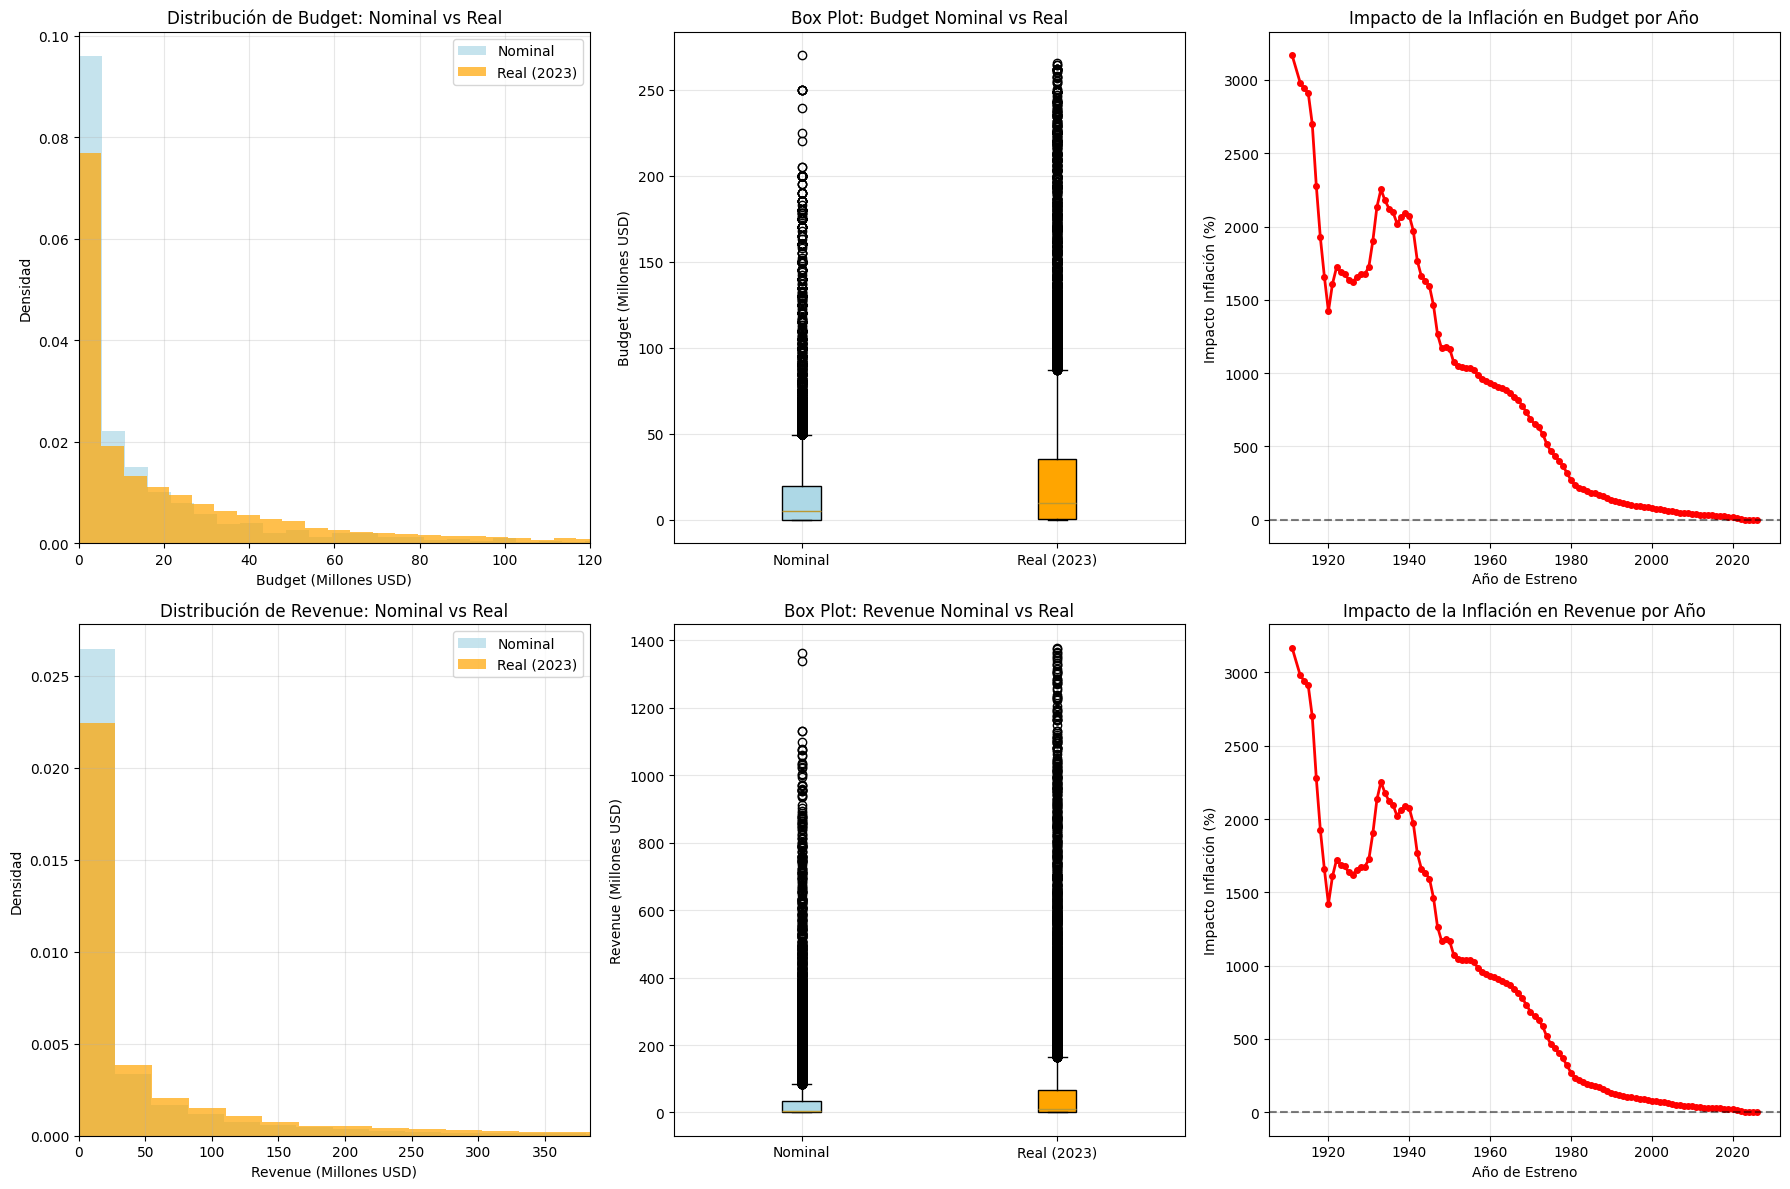

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_distribution_comparison(df, nominal_cols, real_cols):
    """
    Crea gráficos comparativos de distribuciones nominales vs reales
    """
    fig, axes = plt.subplots(len(nominal_cols), 3, figsize=(18, 6 * len(nominal_cols)))

    if len(nominal_cols) == 1:
        axes = axes.reshape(1, -1)

    for i, (nom_col, real_col) in enumerate(zip(nominal_cols, real_cols)):
        # Filter out NaN and infinite values
        mask = (df[nom_col].notna() & df[real_col].notna() &
                np.isfinite(df[nom_col]) & np.isfinite(df[real_col]) &
                (df[nom_col] > 0) & (df[real_col] > 0))

        df_clean = df[mask]

        if len(df_clean) == 0:
            print(f"Warning: No valid data for {nom_col} and {real_col}")
            continue

        # 1. Histogramas comparativos
        nominal_data = df_clean[nom_col] / 1e6
        real_data = df_clean[real_col] / 1e6

        axes[i, 0].hist(nominal_data, bins=50, alpha=0.7, label='Nominal', color='lightblue', density=True)
        axes[i, 0].hist(real_data, bins=50, alpha=0.7, label='Real (2023)', color='orange', density=True)
        axes[i, 0].set_xlabel(f'{nom_col.title()} (Millones USD)')
        axes[i, 0].set_ylabel('Densidad')
        axes[i, 0].set_title(f'Distribución de {nom_col.title()}: Nominal vs Real')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)

        # Safe percentile calculation with fallback
        try:
            upper_limit = np.percentile(real_data, 95)
            if np.isfinite(upper_limit) and upper_limit > 0:
                axes[i, 0].set_xlim(0, upper_limit)
            else:
                # Fallback to max value if percentile fails
                max_val = max(nominal_data.max(), real_data.max())
                if np.isfinite(max_val) and max_val > 0:
                    axes[i, 0].set_xlim(0, max_val * 1.1)
        except Exception as e:
            print(f"Warning: Could not set x-axis limits for {nom_col}: {e}")

        # 2. Box plots comparativos
        box_data = [nominal_data, real_data]
        box_labels = ['Nominal', 'Real (2023)']
        bp = axes[i, 1].boxplot(box_data, labels=box_labels, patch_artist=True)
        bp['boxes'][0].set_facecolor('lightblue')
        bp['boxes'][1].set_facecolor('orange')
        axes[i, 1].set_ylabel(f'{nom_col.title()} (Millones USD)')
        axes[i, 1].set_title(f'Box Plot: {nom_col.title()} Nominal vs Real')
        axes[i, 1].grid(True, alpha=0.3)

        # 3. Evolución temporal de la diferencia
        try:
            yearly_diff = df_clean.groupby('release_year').apply(
                lambda x: ((x[real_col].mean() / x[nom_col].mean()) - 1) * 100
                if x[nom_col].mean() > 0 else np.nan
            ).reset_index()
            yearly_diff.columns = ['year', 'inflation_impact']

            # Remove NaN values from yearly data
            yearly_diff = yearly_diff.dropna()

            if len(yearly_diff) > 0:
                axes[i, 2].plot(yearly_diff['year'], yearly_diff['inflation_impact'],
                                marker='o', linewidth=2, markersize=4, color='red')
                axes[i, 2].set_xlabel('Año de Estreno')
                axes[i, 2].set_ylabel('Impacto Inflación (%)')
                axes[i, 2].set_title(f'Impacto de la Inflación en {nom_col.title()} por Año')
                axes[i, 2].grid(True, alpha=0.3)
                axes[i, 2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
            else:
                axes[i, 2].text(0.5, 0.5, 'No hay datos válidos\npara mostrar',
                               transform=axes[i, 2].transAxes, ha='center', va='center')
                axes[i, 2].set_title(f'Impacto de la Inflación en {nom_col.title()} por Año')
        except Exception as e:
            print(f"Warning: Could not create time evolution plot for {nom_col}: {e}")
            axes[i, 2].text(0.5, 0.5, f'Error en datos\ntemporales',
                           transform=axes[i, 2].transAxes, ha='center', va='center')

    plt.tight_layout()
    plt.show()

# Additional function to diagnose data issues
def diagnose_data_issues(df, nominal_cols, real_cols):
    """
    Diagnóstica problemas en los datos
    """
    print("=== DIAGNÓSTICO DE DATOS ===")
    for nom_col, real_col in zip(nominal_cols, real_cols):
        print(f"\n--- {nom_col.upper()} vs {real_col.upper()} ---")
        print(f"Valores nulos en {nom_col}: {df[nom_col].isna().sum()}")
        print(f"Valores nulos en {real_col}: {df[real_col].isna().sum()}")
        print(f"Valores infinitos en {nom_col}: {np.isinf(df[nom_col]).sum()}")
        print(f"Valores infinitos en {real_col}: {np.isinf(df[real_col]).sum()}")
        print(f"Valores <= 0 en {nom_col}: {(df[nom_col] <= 0).sum()}")
        print(f"Valores <= 0 en {real_col}: {(df[real_col] <= 0).sum()}")

        if nom_col in df.columns and real_col in df.columns:
            valid_mask = (df[nom_col].notna() & df[real_col].notna() &
                         np.isfinite(df[nom_col]) & np.isfinite(df[real_col]) &
                         (df[nom_col] > 0) & (df[real_col] > 0))
            print(f"Filas válidas: {valid_mask.sum()} de {len(df)} total")

        print(f"Rango {nom_col}: {df[nom_col].min():.2e} - {df[nom_col].max():.2e}")
        print(f"Rango {real_col}: {df[real_col].min():.2e} - {df[real_col].max():.2e}")

# Usage example:
# First diagnose the data
diagnose_data_issues(
    df_with_inflation,
    nominal_cols=['budget', 'revenue'],
    real_cols=['budget_real_2023', 'revenue_real_2023']
)

# Then run the fixed plotting function
plot_distribution_comparison(
    df_with_inflation,
    nominal_cols=['budget', 'revenue'],
    real_cols=['budget_real_2023', 'revenue_real_2023']
)

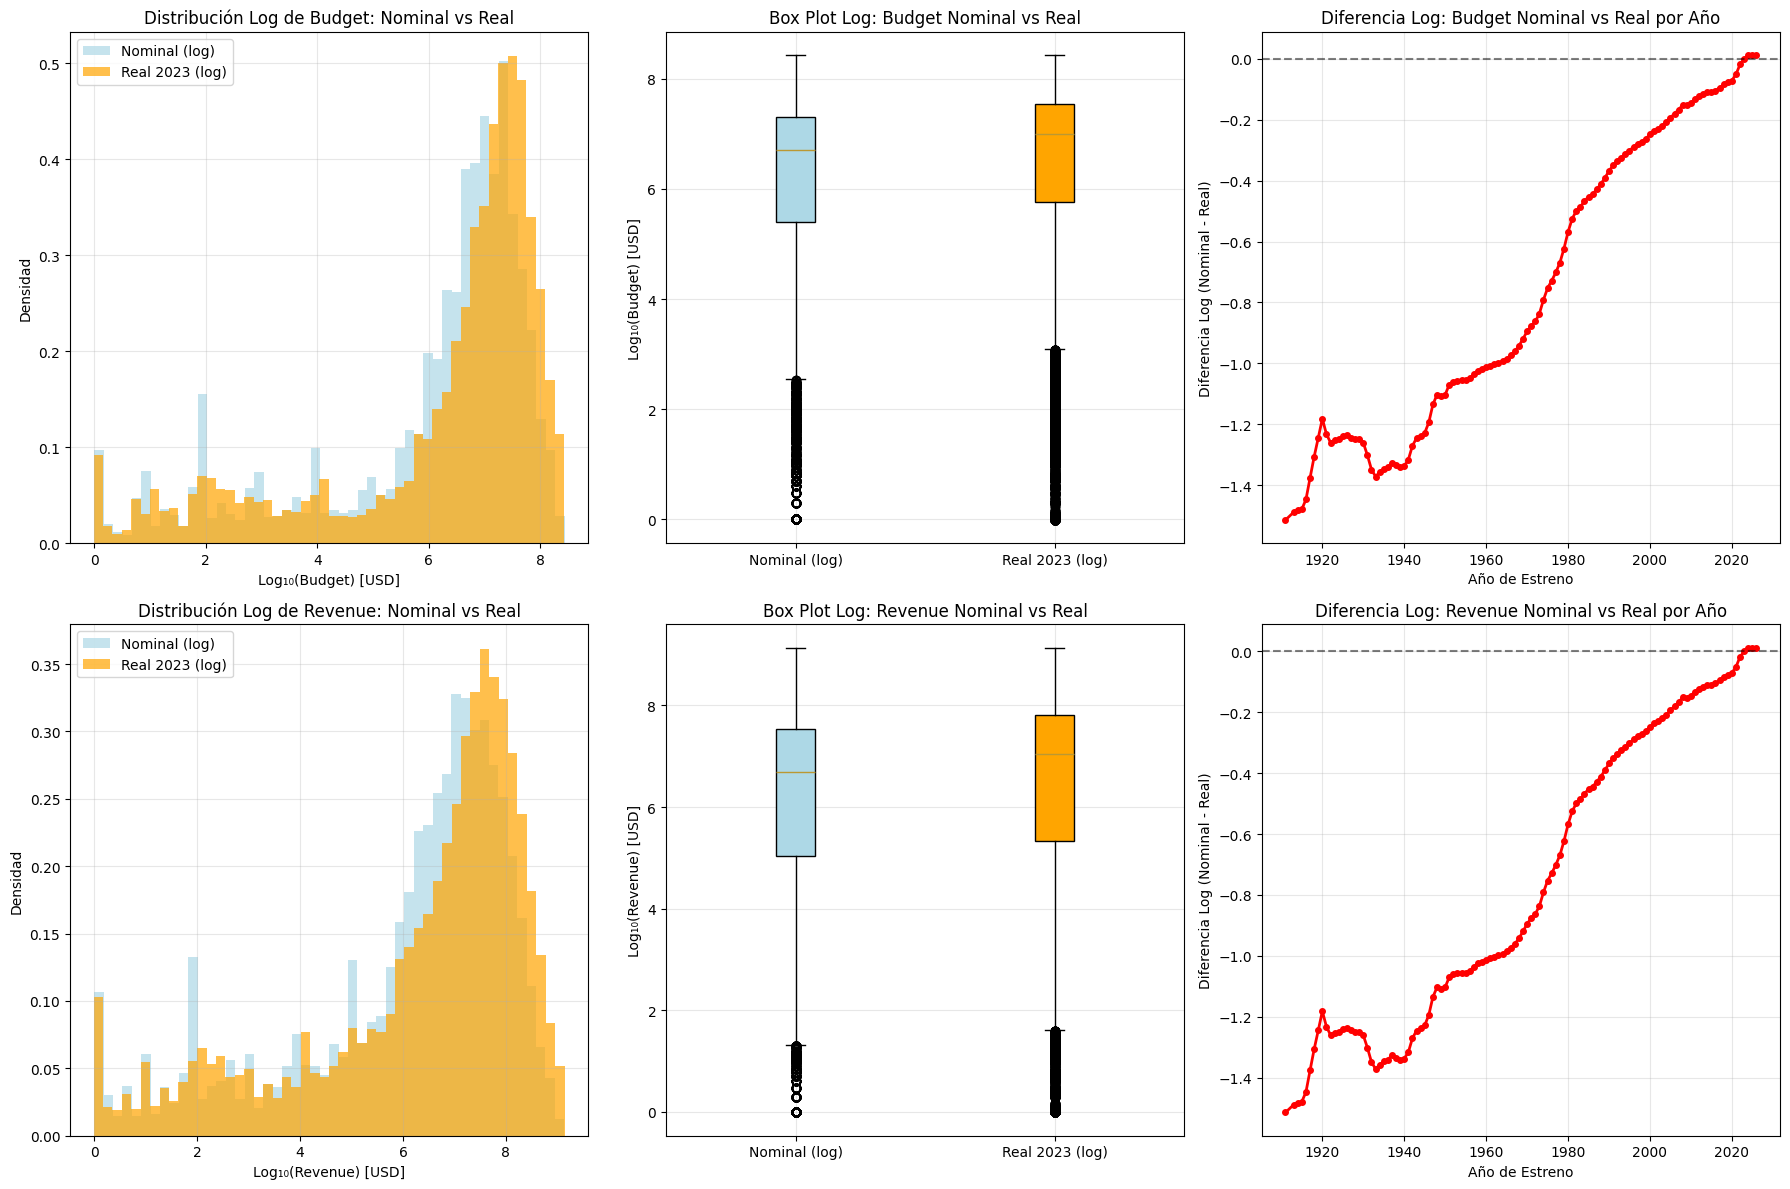

In [9]:
def plot_log_distribution_comparison(df, nominal_cols, real_cols):
    """
    Crea gráficos comparativos de distribuciones nominales vs reales aplicando transformación logarítmica
    """
    fig, axes = plt.subplots(len(nominal_cols), 3, figsize=(18, 6 * len(nominal_cols)))

    if len(nominal_cols) == 1:
        axes = axes.reshape(1, -1)

    for i, (nom_col, real_col) in enumerate(zip(nominal_cols, real_cols)):
        # Filtrar valores positivos para log
        df_positive = df[(df[nom_col] > 0) & (df[real_col] > 0)].copy()

        # Crear variables log
        log_nom = np.log10(df_positive[nom_col])
        log_real = np.log10(df_positive[real_col])

        # 1. Histogramas comparativos (escala logarítmica)
        axes[i, 0].hist(log_nom, bins=50, alpha=0.7, label='Nominal (log)', color='lightblue', density=True)
        axes[i, 0].hist(log_real, bins=50, alpha=0.7, label='Real 2023 (log)', color='orange', density=True)
        axes[i, 0].set_xlabel(f'Log₁₀({nom_col.title()}) [USD]')
        axes[i, 0].set_ylabel('Densidad')
        axes[i, 0].set_title(f'Distribución Log de {nom_col.title()}: Nominal vs Real')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)

        # 2. Box plots comparativos (escala logarítmica)
        box_data = [log_nom, log_real]
        box_labels = ['Nominal (log)', 'Real 2023 (log)']
        bp = axes[i, 1].boxplot(box_data, labels=box_labels, patch_artist=True)
        bp['boxes'][0].set_facecolor('lightblue')
        bp['boxes'][1].set_facecolor('orange')
        axes[i, 1].set_ylabel(f'Log₁₀({nom_col.title()}) [USD]')
        axes[i, 1].set_title(f'Box Plot Log: {nom_col.title()} Nominal vs Real')
        axes[i, 1].grid(True, alpha=0.3)

        # 3. Evolución temporal de la diferencia en escala log
        yearly_stats = df_positive.groupby('release_year').agg({
            nom_col: 'mean',
            real_col: 'mean'
        }).reset_index()

        # Calcular diferencia en logs
        yearly_stats['log_nom_mean'] = np.log10(yearly_stats[nom_col])
        yearly_stats['log_real_mean'] = np.log10(yearly_stats[real_col])
        yearly_stats['log_difference'] = yearly_stats['log_nom_mean'] - yearly_stats['log_real_mean']

        axes[i, 2].plot(yearly_stats['release_year'], yearly_stats['log_difference'],
                        marker='o', linewidth=2, markersize=4, color='red')
        axes[i, 2].set_xlabel('Año de Estreno')
        axes[i, 2].set_ylabel('Diferencia Log (Nominal - Real)')
        axes[i, 2].set_title(f'Diferencia Log: {nom_col.title()} Nominal vs Real por Año')
        axes[i, 2].grid(True, alpha=0.3)
        axes[i, 2].axhline(y=0, color='black', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()



plot_log_distribution_comparison(
    df_with_inflation,
    nominal_cols=['budget', 'revenue'],
    real_cols=['budget_real_2023', 'revenue_real_2023']
)

## 6. Análisis de Correlaciones: Nominal vs Real
#


ANÁLISIS DE CORRELACIONES: VALORES NOMINALES vs REALES

📈 CORRELACIONES BUDGET-REVENUE:
----------------------------------------
Nominal: 0.7401
Real:    0.6679
Cambio:  -9.76%

📅 CORRELACIONES CON AÑO DE ESTRENO:
----------------------------------------
Budget nominal - Año:  0.1058
Budget real - Año:     -0.0746
Revenue nominal - Año: 0.0638
Revenue real - Año:    -0.0960


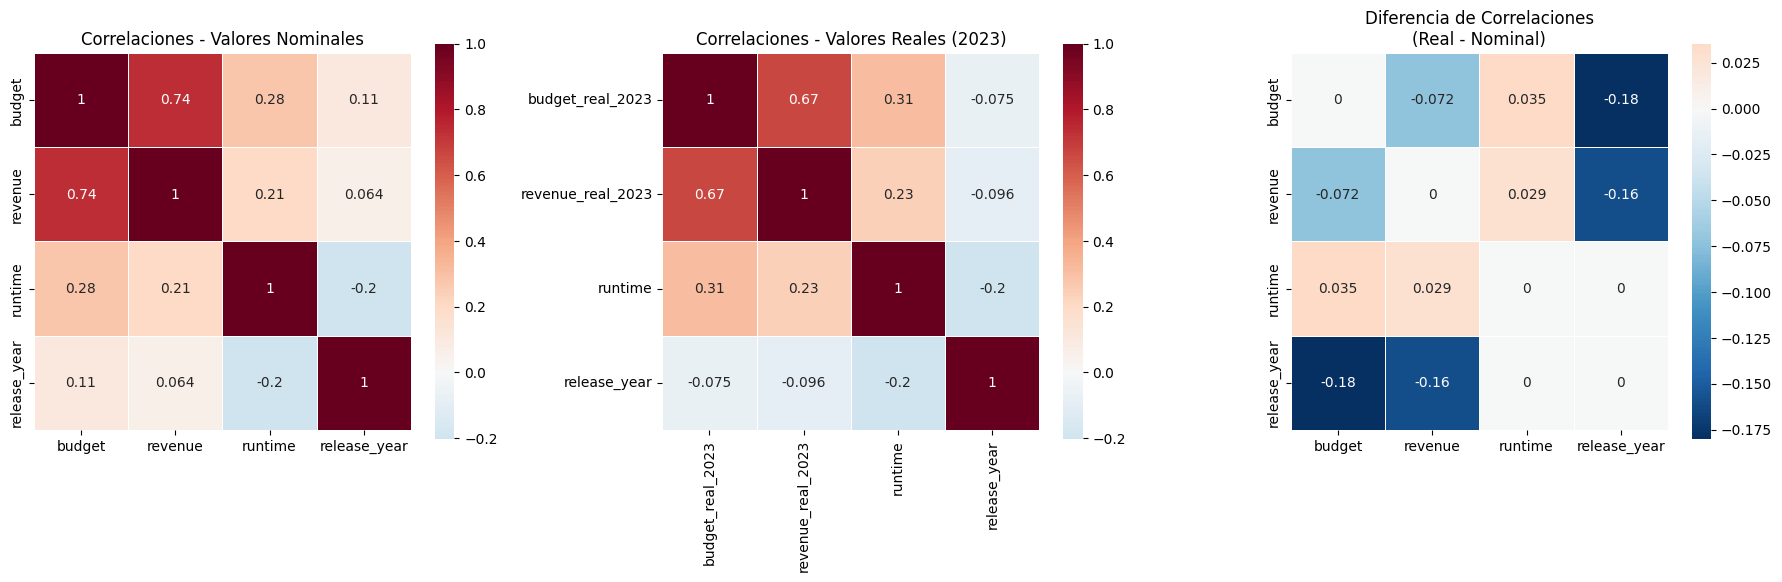

In [10]:
def correlation_analysis_comparison(df):
    """
    Compara correlaciones entre variables nominales y reales
    """
    print("=" * 80)
    print("ANÁLISIS DE CORRELACIONES: VALORES NOMINALES vs REALES")
    print("=" * 80)

    # Variables para análisis de correlación
    analysis_vars = {
        'nominal': ['budget', 'revenue', 'runtime', 'release_year'],
        'real': ['budget_real_2023', 'revenue_real_2023', 'runtime', 'release_year']
    }

    # Calcular matrices de correlación
    corr_nominal = df[analysis_vars['nominal']].corr()
    corr_real = df[analysis_vars['real']].corr()

    # Mostrar correlaciones clave
    print("\n📈 CORRELACIONES BUDGET-REVENUE:")
    print("-" * 40)
    budget_revenue_nom = corr_nominal.loc['budget', 'revenue']
    budget_revenue_real = corr_real.loc['budget_real_2023', 'revenue_real_2023']

    print(f"Nominal: {budget_revenue_nom:.4f}")
    print(f"Real:    {budget_revenue_real:.4f}")
    print(f"Cambio:  {((budget_revenue_real / budget_revenue_nom) - 1) * 100:+.2f}%")

    # Correlaciones con año
    print(f"\n📅 CORRELACIONES CON AÑO DE ESTRENO:")
    print("-" * 40)
    print(f"Budget nominal - Año:  {corr_nominal.loc['budget', 'release_year']:.4f}")
    print(f"Budget real - Año:     {corr_real.loc['budget_real_2023', 'release_year']:.4f}")
    print(f"Revenue nominal - Año: {corr_nominal.loc['revenue', 'release_year']:.4f}")
    print(f"Revenue real - Año:    {corr_real.loc['revenue_real_2023', 'release_year']:.4f}")

    # Visualizar matrices de correlación
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Matriz nominal
    sns.heatmap(corr_nominal, annot=True, cmap='RdBu_r', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=axes[0])
    axes[0].set_title('Correlaciones - Valores Nominales')

    # Matriz real
    sns.heatmap(corr_real, annot=True, cmap='RdBu_r', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=axes[1])
    axes[1].set_title('Correlaciones - Valores Reales (2023)')

    # Diferencia entre matrices - necesitamos alinear las dimensiones
    # Crear una matriz de diferencias con los nombres correctos
    common_vars = ['budget', 'revenue', 'runtime', 'release_year']

    # Mapear variables reales a nominales para la comparación
    real_to_nominal_map = {
        'budget_real_2023': 'budget',
        'revenue_real_2023': 'revenue',
        'runtime': 'runtime',
        'release_year': 'release_year'
    }

    # Crear matriz de diferencias alineada
    corr_diff = pd.DataFrame(index=common_vars, columns=common_vars)

    for i, var1 in enumerate(common_vars):
        for j, var2 in enumerate(common_vars):
            real_var1 = var1 + '_real_2023' if var1 in ['budget', 'revenue'] else var1
            real_var2 = var2 + '_real_2023' if var2 in ['budget', 'revenue'] else var2

            if real_var1 in corr_real.index and real_var2 in corr_real.columns:
                corr_diff.loc[var1, var2] = (corr_real.loc[real_var1, real_var2] -
                                             corr_nominal.loc[var1, var2])
            else:
                corr_diff.loc[var1, var2] = 0

    corr_diff = corr_diff.astype(float)

    sns.heatmap(corr_diff, annot=True, cmap='RdBu_r', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=axes[2])
    axes[2].set_title('Diferencia de Correlaciones\n(Real - Nominal)')

    plt.tight_layout()
    plt.show()

    return corr_nominal, corr_real, corr_diff



corr_nom, corr_real, corr_diff = correlation_analysis_comparison(df_with_inflation)



## 7. Análisis de Tendencias Temporales
#


ANÁLISIS DE TENDENCIAS TEMPORALES
Período de análisis: 1924 - 2026
Años con datos suficientes (≥5 películas): 103


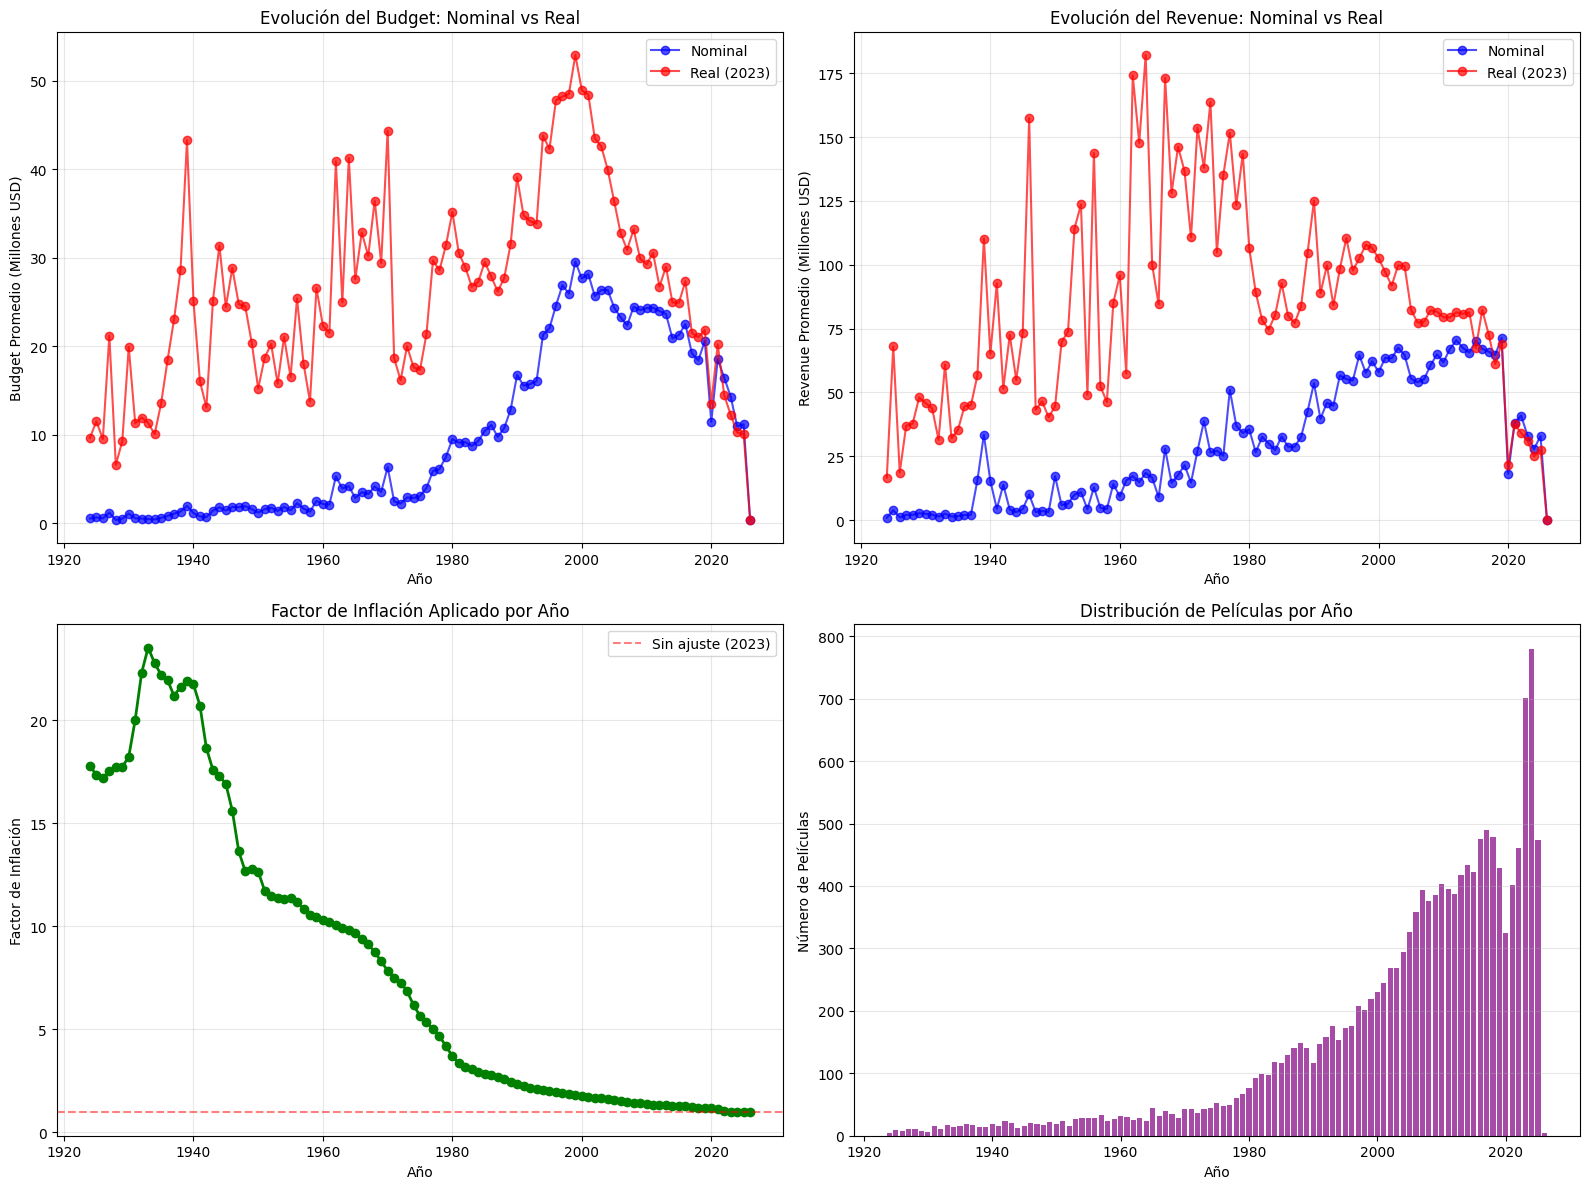

In [11]:
def temporal_trends_analysis(df):
    """
    Analiza tendencias temporales de valores nominales vs reales
    """
    print("=" * 80)
    print("ANÁLISIS DE TENDENCIAS TEMPORALES")
    print("=" * 80)

    # Agrupar por año
    yearly_stats = df.groupby('release_year').agg({
        'budget': ['mean', 'median', 'count'],
        'revenue': ['mean', 'median'],
        'budget_real_2023': ['mean', 'median'],
        'revenue_real_2023': ['mean', 'median'],
        'inflation_factor': 'mean'
    }).round(2)

    # Aplanar nombres de columnas
    yearly_stats.columns = ['_'.join(col) for col in yearly_stats.columns]
    yearly_stats = yearly_stats.reset_index()

    # Filtrar años con suficientes datos
    yearly_stats = yearly_stats[yearly_stats['budget_count'] >= 5]

    print(f"Período de análisis: {yearly_stats['release_year'].min():.0f} - {yearly_stats['release_year'].max():.0f}")
    print(f"Años con datos suficientes (≥5 películas): {len(yearly_stats)}")

    # Crear visualización de tendencias
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Evolución de Budget
    axes[0, 0].plot(yearly_stats['release_year'], yearly_stats['budget_mean'] / 1e6,
                    'o-', label='Nominal', color='blue', alpha=0.7)
    axes[0, 0].plot(yearly_stats['release_year'], yearly_stats['budget_real_2023_mean'] / 1e6,
                    'o-', label='Real (2023)', color='red', alpha=0.7)
    axes[0, 0].set_xlabel('Año')
    axes[0, 0].set_ylabel('Budget Promedio (Millones USD)')
    axes[0, 0].set_title('Evolución del Budget: Nominal vs Real')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Evolución de Revenue
    axes[0, 1].plot(yearly_stats['release_year'], yearly_stats['revenue_mean'] / 1e6,
                    'o-', label='Nominal', color='blue', alpha=0.7)
    axes[0, 1].plot(yearly_stats['release_year'], yearly_stats['revenue_real_2023_mean'] / 1e6,
                    'o-', label='Real (2023)', color='red', alpha=0.7)
    axes[0, 1].set_xlabel('Año')
    axes[0, 1].set_ylabel('Revenue Promedio (Millones USD)')
    axes[0, 1].set_title('Evolución del Revenue: Nominal vs Real')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Factor de inflación aplicado
    axes[1, 0].plot(yearly_stats['release_year'], yearly_stats['inflation_factor_mean'],
                    'o-', color='green', linewidth=2)
    axes[1, 0].set_xlabel('Año')
    axes[1, 0].set_ylabel('Factor de Inflación')
    axes[1, 0].set_title('Factor de Inflación Aplicado por Año')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Sin ajuste (2023)')
    axes[1, 0].legend()

    # 4. Número de películas por año
    axes[1, 1].bar(yearly_stats['release_year'], yearly_stats['budget_count'],
                   alpha=0.7, color='purple')
    axes[1, 1].set_xlabel('Año')
    axes[1, 1].set_ylabel('Número de Películas')
    axes[1, 1].set_title('Distribución de Películas por Año')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    return yearly_stats


yearly_trends = temporal_trends_analysis(df_with_inflation)



## 8. Análisis de ROI: Nominal vs Real
#


ANÁLISIS DE ROI: VALORES NOMINALES vs REALES
📊 ESTADÍSTICAS DE ROI:
----------------------------------------
        ROI_Nominal      ROI_Real
count  1.536500e+04  1.483100e+04
mean   8.193378e+06  7.799159e+06
std    8.149883e+08  8.254615e+08
min   -1.000000e+02 -1.000000e+02
25%   -4.039000e+01 -4.187000e+01
50%    4.815000e+01  4.673000e+01
75%    2.478700e+02  2.421800e+02
max    1.000000e+11  1.000000e+11

Diferencia promedio (Real - Nominal): -394219.25 puntos porcentuales

📈 ROI POR DÉCADA:
--------------------------------------------------
        roi_nom_mean  roi_nom_median  roi_real_mean  roi_real_median  count
decade                                                                     
1910.0       3562.86          514.90        3562.86           514.90     16
1920.0        473.09          204.77         473.09           204.77     58
1930.0        521.82          137.69         370.11           133.06    142
1940.0        527.79          121.96         313.79           114

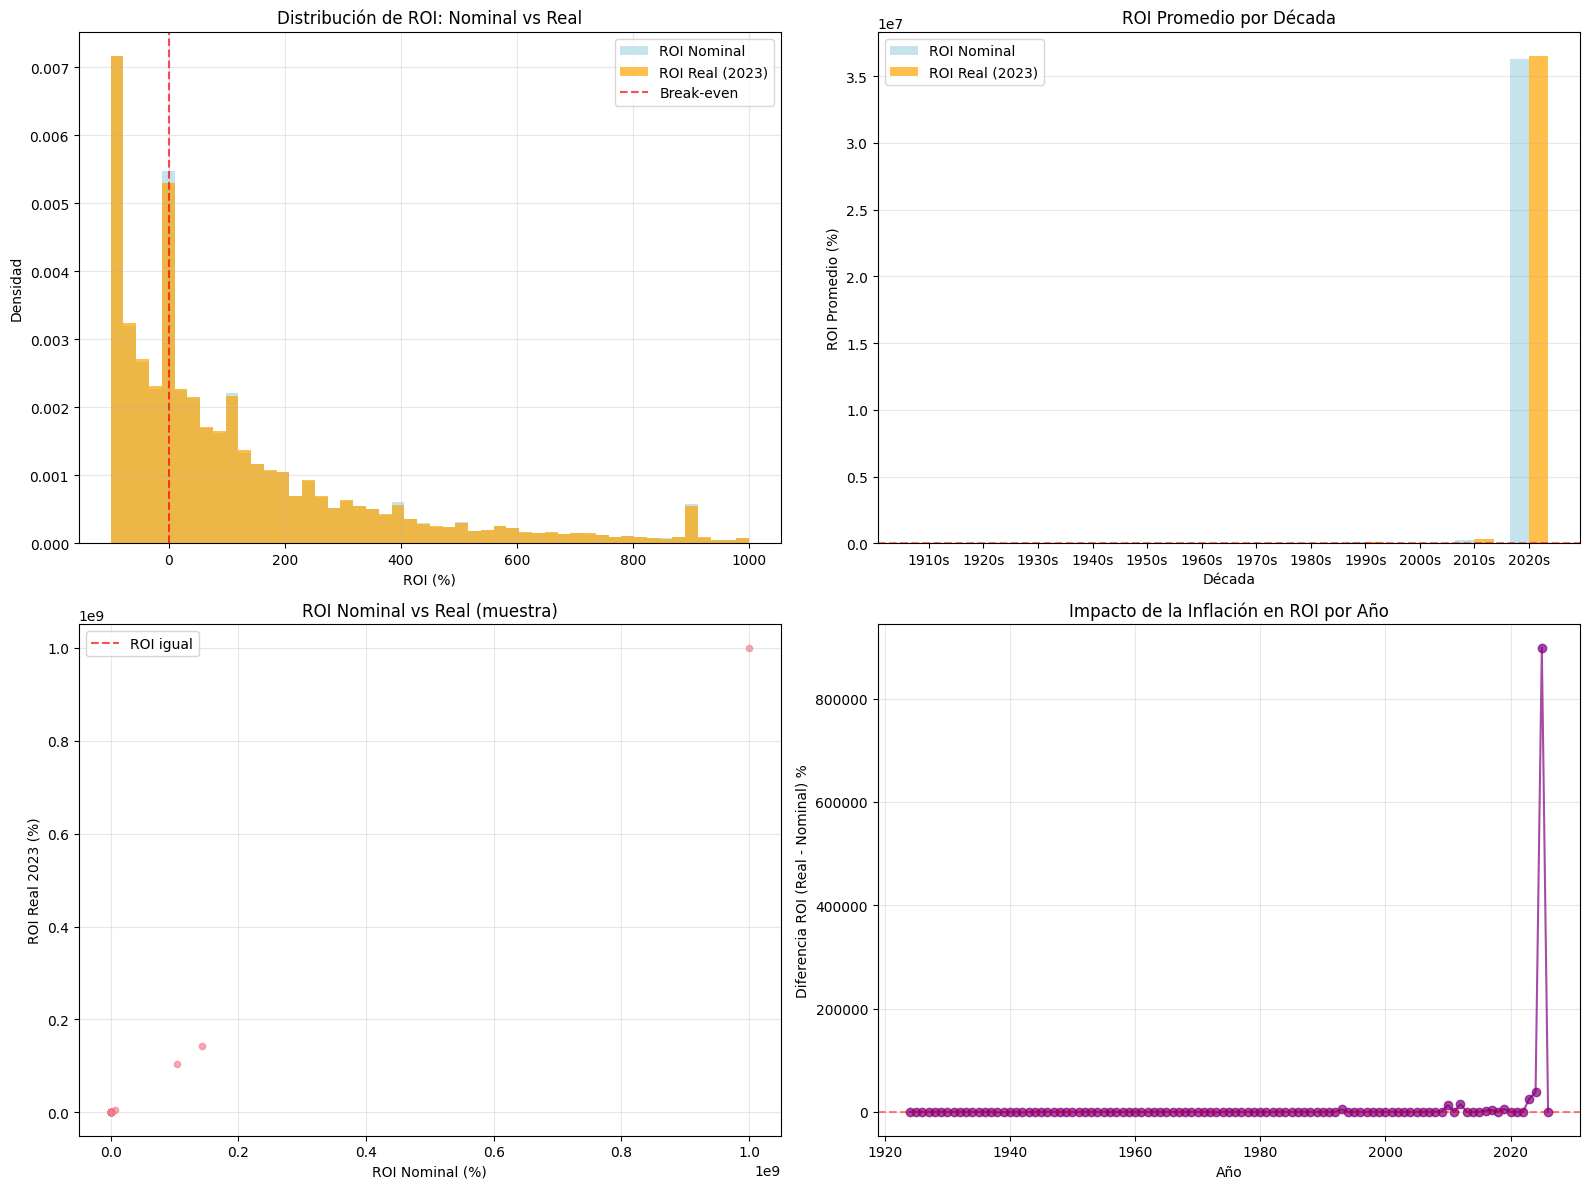

In [12]:
def roi_analysis_comparison(df):
    """
    Compara análisis de ROI entre valores nominales y reales
    """
    print("=" * 80)
    print("ANÁLISIS DE ROI: VALORES NOMINALES vs REALES")
    print("=" * 80)

    # Calcular ROI nominal y real
    df['roi_nominal'] = ((df['revenue'] - df['budget']) / df['budget']) * 100
    df['roi_real'] = ((df['revenue_real_2023'] - df['budget_real_2023']) / df['budget_real_2023']) * 100

    # Estadísticas de ROI
    print("📊 ESTADÍSTICAS DE ROI:")
    print("-" * 40)

    roi_stats = pd.DataFrame({
        'ROI_Nominal': df['roi_nominal'].describe(),
        'ROI_Real': df['roi_real'].describe()
    }).round(2)

    print(roi_stats)

    # Diferencia promedio
    avg_diff = df['roi_real'].mean() - df['roi_nominal'].mean()
    print(f"\nDiferencia promedio (Real - Nominal): {avg_diff:.2f} puntos porcentuales")

    # Análisis por décadas
    df['decade'] = (df['release_year'] // 10) * 10
    decade_roi = df.groupby('decade').agg({
        'roi_nominal': ['mean', 'median'],
        'roi_real': ['mean', 'median'],
        'release_year': 'count'  # para contar películas
    }).round(2)

    decade_roi.columns = ['roi_nom_mean', 'roi_nom_median', 'roi_real_mean', 'roi_real_median', 'count']
    decade_roi = decade_roi[decade_roi['count'] >= 10]  # Solo décadas con suficientes datos

    print(f"\n📈 ROI POR DÉCADA:")
    print("-" * 50)
    print(decade_roi)

    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Distribución de ROI
    roi_filtered_nom = df['roi_nominal'][(df['roi_nominal'] > -100) & (df['roi_nominal'] < 1000)]
    roi_filtered_real = df['roi_real'][(df['roi_real'] > -100) & (df['roi_real'] < 1000)]

    axes[0, 0].hist(roi_filtered_nom, bins=50, alpha=0.7, label='ROI Nominal', color='lightblue', density=True)
    axes[0, 0].hist(roi_filtered_real, bins=50, alpha=0.7, label='ROI Real (2023)', color='orange', density=True)
    axes[0, 0].axvline(0, color='red', linestyle='--', alpha=0.7, label='Break-even')
    axes[0, 0].set_xlabel('ROI (%)')
    axes[0, 0].set_ylabel('Densidad')
    axes[0, 0].set_title('Distribución de ROI: Nominal vs Real')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. ROI por década
    x = np.arange(len(decade_roi))
    width = 0.35

    axes[0, 1].bar(x - width / 2, decade_roi['roi_nom_mean'], width,
                   label='ROI Nominal', alpha=0.7, color='lightblue')
    axes[0, 1].bar(x + width / 2, decade_roi['roi_real_mean'], width,
                   label='ROI Real (2023)', alpha=0.7, color='orange')
    axes[0, 1].set_xlabel('Década')
    axes[0, 1].set_ylabel('ROI Promedio (%)')
    axes[0, 1].set_title('ROI Promedio por Década')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels([f"{int(d)}s" for d in decade_roi.index])
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    axes[0, 1].axhline(0, color='red', linestyle='--', alpha=0.5)

    # 3. Scatter plot: ROI nominal vs real
    sample_idx = np.random.choice(len(df), min(1000, len(df)), replace=False)  # Muestra para visualización
    df_sample = df.iloc[sample_idx]

    axes[1, 0].scatter(df_sample['roi_nominal'], df_sample['roi_real'], alpha=0.6, s=20)
    max_roi = max(df_sample['roi_nominal'].quantile(0.95), df_sample['roi_real'].quantile(0.95))
    min_roi = min(df_sample['roi_nominal'].quantile(0.05), df_sample['roi_real'].quantile(0.05))
    axes[1, 0].plot([min_roi, max_roi], [min_roi, max_roi], 'r--', alpha=0.7, label='ROI igual')
    axes[1, 0].set_xlabel('ROI Nominal (%)')
    axes[1, 0].set_ylabel('ROI Real 2023 (%)')
    axes[1, 0].set_title('ROI Nominal vs Real (muestra)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Diferencia de ROI por año
    yearly_roi_diff = df.groupby('release_year').apply(
        lambda x: x['roi_real'].mean() - x['roi_nominal'].mean()
    ).reset_index()
    yearly_roi_diff.columns = ['year', 'roi_difference']

    # Filtrar años con suficientes datos
    year_counts = df.groupby('release_year').size()
    yearly_roi_diff = yearly_roi_diff[yearly_roi_diff['year'].isin(year_counts[year_counts >= 5].index)]

    axes[1, 1].plot(yearly_roi_diff['year'], yearly_roi_diff['roi_difference'],
                    'o-', color='purple', alpha=0.7)
    axes[1, 1].set_xlabel('Año')
    axes[1, 1].set_ylabel('Diferencia ROI (Real - Nominal) %')
    axes[1, 1].set_title('Impacto de la Inflación en ROI por Año')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(0, color='red', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    return df[['roi_nominal', 'roi_real']], decade_roi



roi_comparison, decade_roi_stats = roi_analysis_comparison(df_with_inflation)



## 9. Análisis Comparativo de Regresiones
#


ANÁLISIS COMPARATIVO DE REGRESIONES: NOMINAL vs REAL
📊 MÉTRICAS DE REGRESIÓN:
--------------------------------------------------
Modelo               | R²       | Correlación 
--------------------------------------------------
Nominal Linear       | 0.5305   | 0.7284      
Real Linear          | 0.4461   | 0.6679      
Nominal Log          | 0.8252   | 0.9084      
Real Log             | 0.8361   | 0.9144      

📈 CAMBIOS POR AJUSTE DE INFLACIÓN:
--------------------------------------------------
R² Linear - Cambio: -15.92%
R² Log - Cambio: +1.32%
Correlación Linear - Cambio: -8.30%
Correlación Log - Cambio: +0.66%


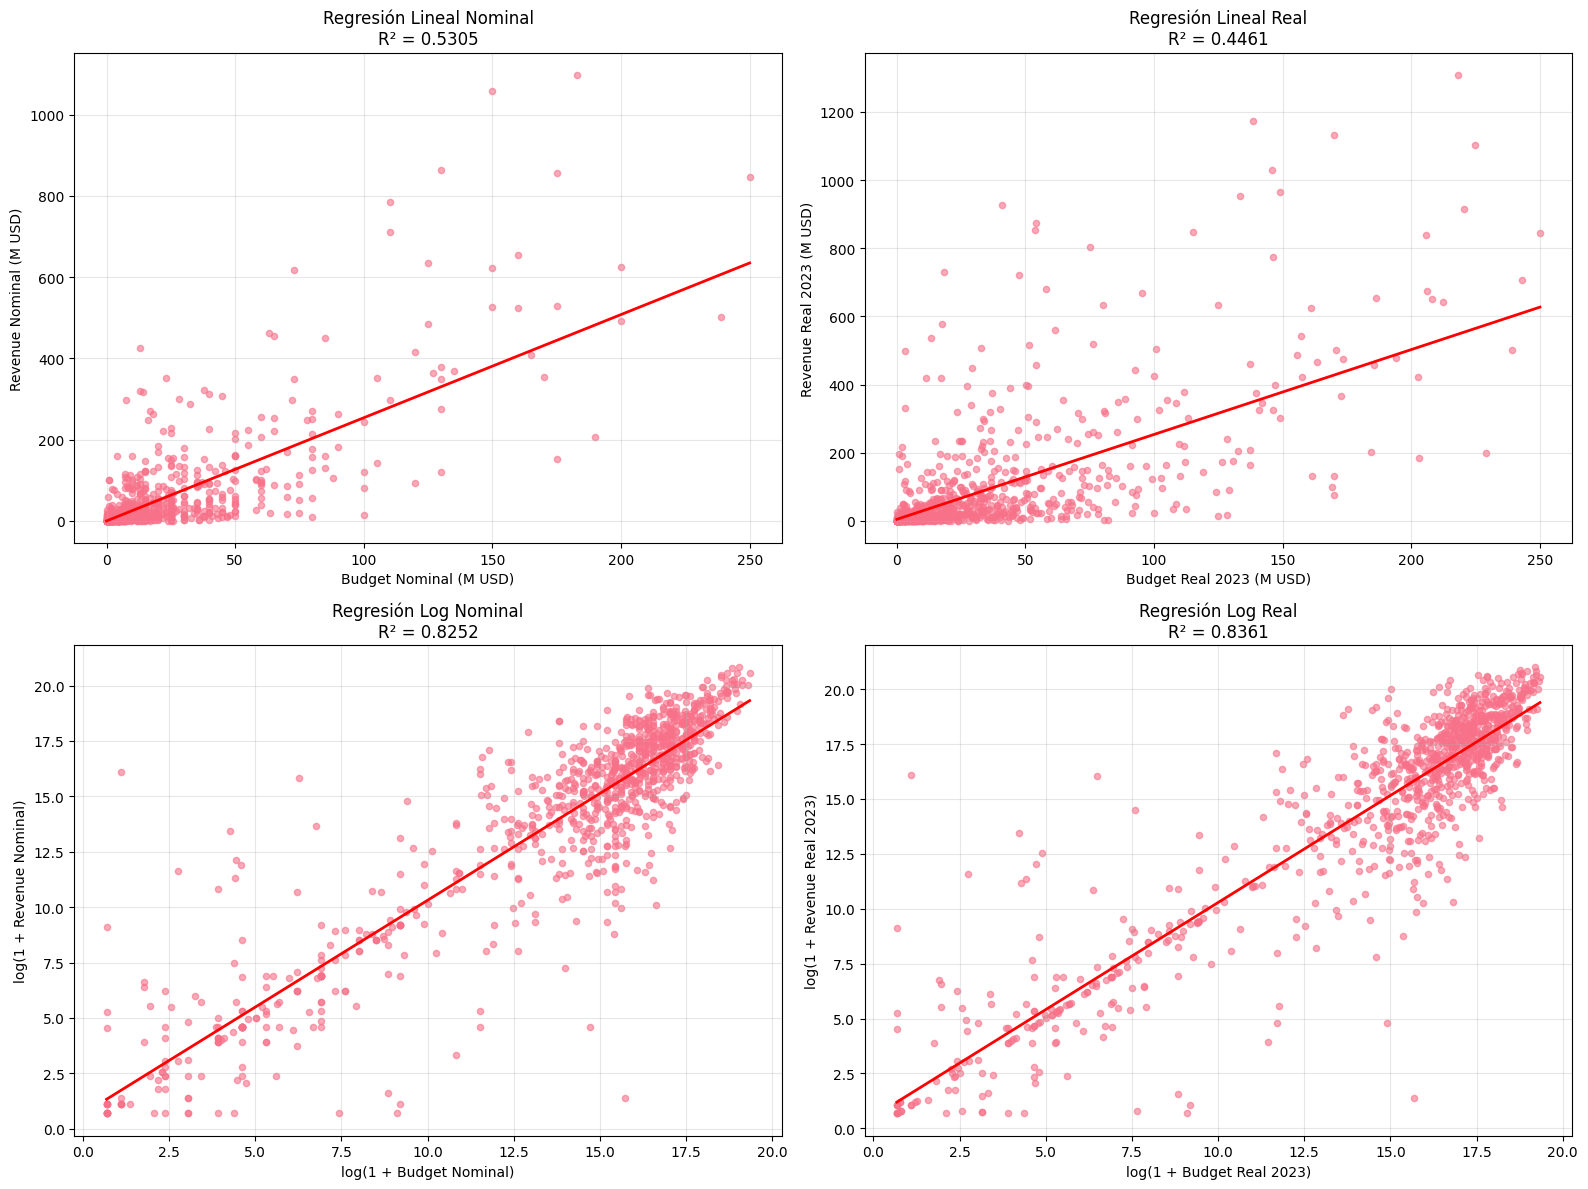

In [13]:
def regression_comparison_analysis(df):
    """
    Compara modelos de regresión entre valores nominales y reales
    """
    print("=" * 80)
    print("ANÁLISIS COMPARATIVO DE REGRESIONES: NOMINAL vs REAL")
    print("=" * 80)

    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score

    # Preparar datos
    valid_mask = (df['budget'] > 0) & (df['revenue'] > 0) & \
                 (df['budget_real_2023'] > 0) & (df['revenue_real_2023'] > 0)
    df_reg = df[valid_mask].copy()

    # Variables para regresión
    X_nom = df_reg[['budget']].values
    y_nom = df_reg['revenue'].values
    X_real = df_reg[['budget_real_2023']].values
    y_real = df_reg['revenue_real_2023'].values

    # Versiones logarítmicas
    X_nom_log = np.log1p(df_reg[['budget']]).values
    y_nom_log = np.log1p(df_reg['revenue']).values
    X_real_log = np.log1p(df_reg[['budget_real_2023']]).values
    y_real_log = np.log1p(df_reg['revenue_real_2023']).values

    # Ajustar modelos
    models = {}

    # Modelos lineales
    models['nominal_linear'] = LinearRegression().fit(X_nom, y_nom)
    models['real_linear'] = LinearRegression().fit(X_real, y_real)

    # Modelos logarítmicos
    models['nominal_log'] = LinearRegression().fit(X_nom_log, y_nom_log)
    models['real_log'] = LinearRegression().fit(X_real_log, y_real_log)

    # Calcular métricas
    metrics = {}

    # R² para modelos lineales
    metrics['r2_nom_linear'] = models['nominal_linear'].score(X_nom, y_nom)
    metrics['r2_real_linear'] = models['real_linear'].score(X_real, y_real)

    # R² para modelos logarítmicos
    metrics['r2_nom_log'] = models['nominal_log'].score(X_nom_log, y_nom_log)
    metrics['r2_real_log'] = models['real_log'].score(X_real_log, y_real_log)

    # Correlaciones
    metrics['corr_nom_linear'] = pearsonr(df_reg['budget'], df_reg['revenue'])[0]
    metrics['corr_real_linear'] = pearsonr(df_reg['budget_real_2023'], df_reg['revenue_real_2023'])[0]
    metrics['corr_nom_log'] = pearsonr(np.log1p(df_reg['budget']), np.log1p(df_reg['revenue']))[0]
    metrics['corr_real_log'] = pearsonr(np.log1p(df_reg['budget_real_2023']), np.log1p(df_reg['revenue_real_2023']))[0]

    # Mostrar resultados
    print("📊 MÉTRICAS DE REGRESIÓN:")
    print("-" * 50)
    print(f"{'Modelo':<20} | {'R²':<8} | {'Correlación':<12}")
    print("-" * 50)
    print(f"{'Nominal Linear':<20} | {metrics['r2_nom_linear']:<8.4f} | {metrics['corr_nom_linear']:<12.4f}")
    print(f"{'Real Linear':<20} | {metrics['r2_real_linear']:<8.4f} | {metrics['corr_real_linear']:<12.4f}")
    print(f"{'Nominal Log':<20} | {metrics['r2_nom_log']:<8.4f} | {metrics['corr_nom_log']:<12.4f}")
    print(f"{'Real Log':<20} | {metrics['r2_real_log']:<8.4f} | {metrics['corr_real_log']:<12.4f}")

    print(f"\n📈 CAMBIOS POR AJUSTE DE INFLACIÓN:")
    print("-" * 50)
    r2_change_linear = ((metrics['r2_real_linear'] / metrics['r2_nom_linear']) - 1) * 100
    r2_change_log = ((metrics['r2_real_log'] / metrics['r2_nom_log']) - 1) * 100
    corr_change_linear = ((metrics['corr_real_linear'] / metrics['corr_nom_linear']) - 1) * 100
    corr_change_log = ((metrics['corr_real_log'] / metrics['corr_nom_log']) - 1) * 100

    print(f"R² Linear - Cambio: {r2_change_linear:+.2f}%")
    print(f"R² Log - Cambio: {r2_change_log:+.2f}%")
    print(f"Correlación Linear - Cambio: {corr_change_linear:+.2f}%")
    print(f"Correlación Log - Cambio: {corr_change_log:+.2f}%")

    # Visualización comparativa
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Regresión lineal nominal
    sample_size = min(1000, len(df_reg))
    sample_idx = np.random.choice(len(df_reg), sample_size, replace=False)
    df_sample = df_reg.iloc[sample_idx]

    axes[0, 0].scatter(df_sample['budget'] / 1e6, df_sample['revenue'] / 1e6, alpha=0.6, s=20)
    x_range = np.linspace(df_sample['budget'].min(), df_sample['budget'].max(), 100)
    y_pred = models['nominal_linear'].predict(x_range.reshape(-1, 1))
    axes[0, 0].plot(x_range / 1e6, y_pred / 1e6, 'r-', linewidth=2)
    axes[0, 0].set_xlabel('Budget Nominal (M USD)')
    axes[0, 0].set_ylabel('Revenue Nominal (M USD)')
    axes[0, 0].set_title(f'Regresión Lineal Nominal\nR² = {metrics["r2_nom_linear"]:.4f}')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Regresión lineal real
    axes[0, 1].scatter(df_sample['budget_real_2023'] / 1e6, df_sample['revenue_real_2023'] / 1e6, alpha=0.6, s=20)
    x_range_real = np.linspace(df_sample['budget_real_2023'].min(), df_sample['budget_real_2023'].max(), 100)
    y_pred_real = models['real_linear'].predict(x_range_real.reshape(-1, 1))
    axes[0, 1].plot(x_range_real / 1e6, y_pred_real / 1e6, 'r-', linewidth=2)
    axes[0, 1].set_xlabel('Budget Real 2023 (M USD)')
    axes[0, 1].set_ylabel('Revenue Real 2023 (M USD)')
    axes[0, 1].set_title(f'Regresión Lineal Real\nR² = {metrics["r2_real_linear"]:.4f}')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Regresión logarítmica nominal
    axes[1, 0].scatter(np.log1p(df_sample['budget']), np.log1p(df_sample['revenue']), alpha=0.6, s=20)
    x_log_range = np.linspace(np.log1p(df_sample['budget']).min(), np.log1p(df_sample['budget']).max(), 100)
    y_log_pred = models['nominal_log'].predict(x_log_range.reshape(-1, 1))
    axes[1, 0].plot(x_log_range, y_log_pred, 'r-', linewidth=2)
    axes[1, 0].set_xlabel('log(1 + Budget Nominal)')
    axes[1, 0].set_ylabel('log(1 + Revenue Nominal)')
    axes[1, 0].set_title(f'Regresión Log Nominal\nR² = {metrics["r2_nom_log"]:.4f}')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Regresión logarítmica real
    axes[1, 1].scatter(np.log1p(df_sample['budget_real_2023']), np.log1p(df_sample['revenue_real_2023']), alpha=0.6,
                       s=20)
    x_log_range_real = np.linspace(np.log1p(df_sample['budget_real_2023']).min(),
                                   np.log1p(df_sample['budget_real_2023']).max(), 100)
    y_log_pred_real = models['real_log'].predict(x_log_range_real.reshape(-1, 1))
    axes[1, 1].plot(x_log_range_real, y_log_pred_real, 'r-', linewidth=2)
    axes[1, 1].set_xlabel('log(1 + Budget Real 2023)')
    axes[1, 1].set_ylabel('log(1 + Revenue Real 2023)')
    axes[1, 1].set_title(f'Regresión Log Real\nR² = {metrics["r2_real_log"]:.4f}')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return models, metrics



regression_models, regression_metrics = regression_comparison_analysis(df_with_inflation)



## 10. Análisis por Categorías de Presupuesto
#


ANÁLISIS POR CATEGORÍAS DE PRESUPUESTO
📊 IMPACTO DE LA INFLACIÓN POR CATEGORÍA DE PRESUPUESTO:
----------------------------------------------------------------------
Categoría  | Count  | Año Prom  | Budget +%  | Revenue +%
----------------------------------------------------------------------
<1M        | 5311   | 2006.8    | 414.8      | 228.3     
1-10M      | 4538   | 1999.7    | 147.3      | 173.0     
10-50M     | 4128   | 2004.7    | 69.7       | 70.6      
50-100M    | 896    | 2007.9    | 49.8       | 38.9      
>100M      | 492    | 2013.2    | 18.5       | 9.2       


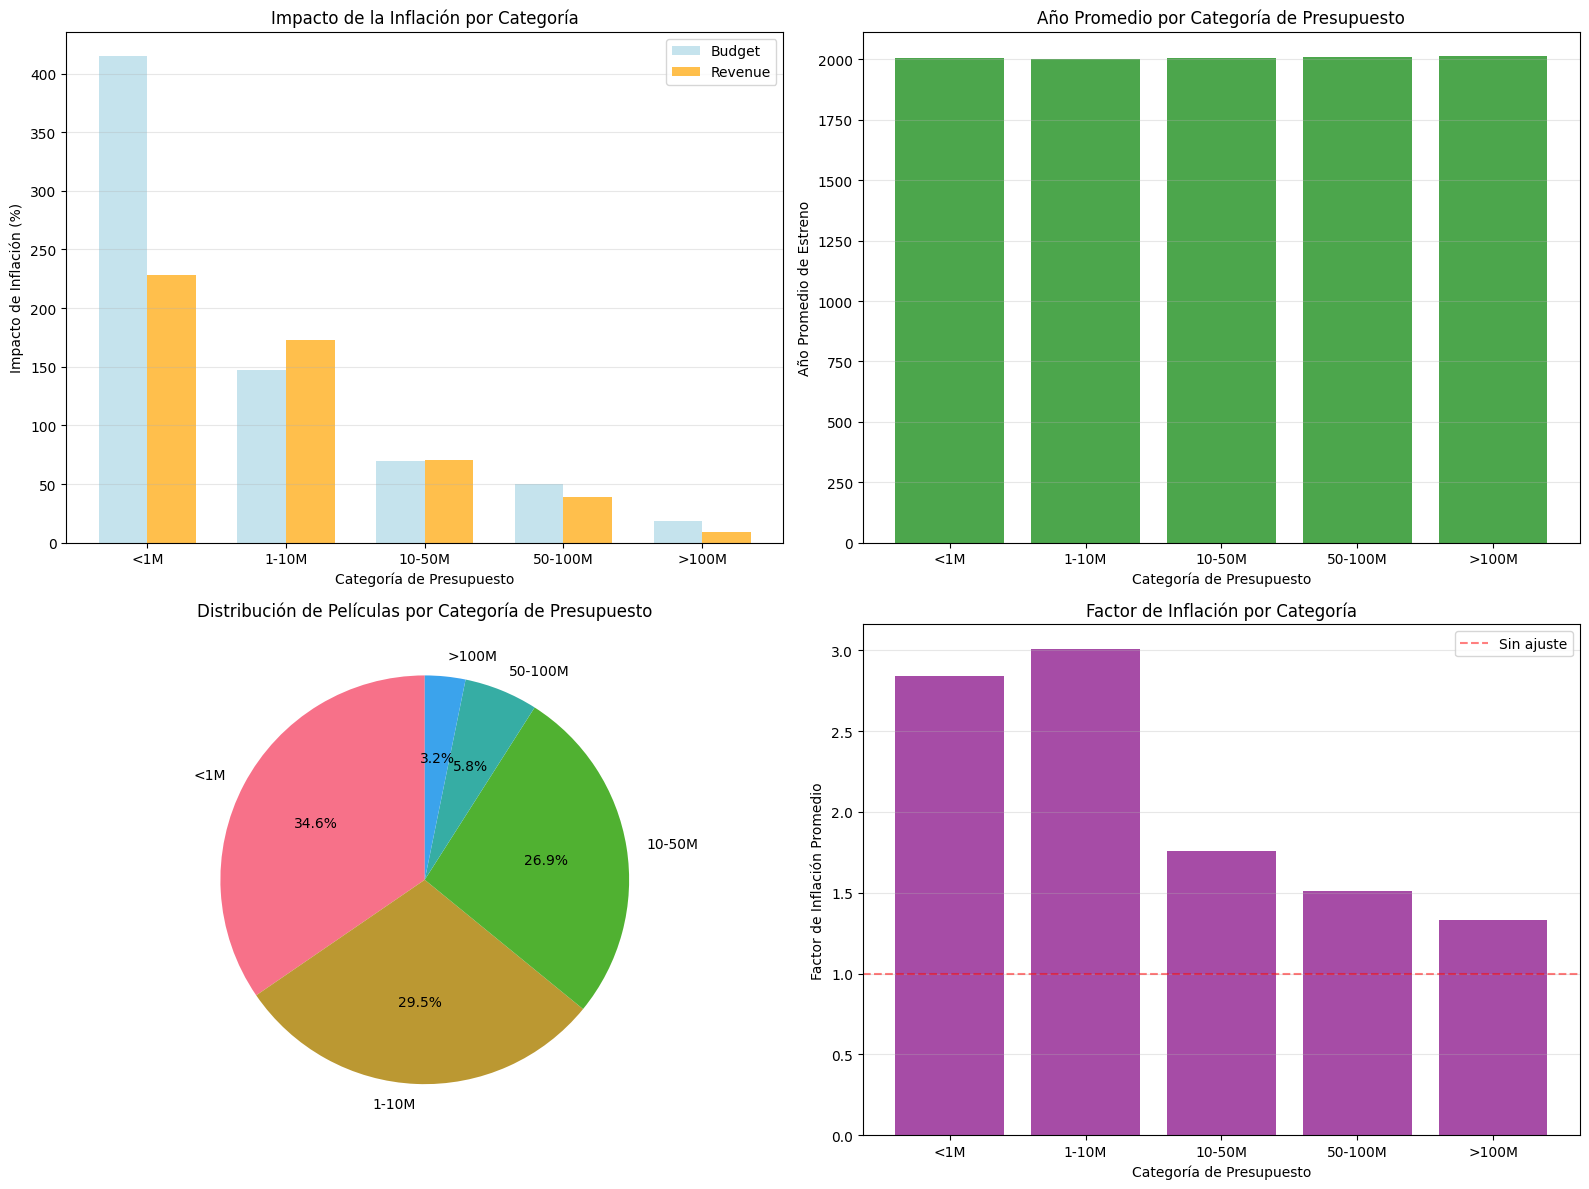

In [14]:
def budget_category_analysis(df):
    """
    Analiza el impacto de la inflación por categorías de presupuesto
    """
    print("=" * 80)
    print("ANÁLISIS POR CATEGORÍAS DE PRESUPUESTO")
    print("=" * 80)

    # Crear categorías de presupuesto basadas en valores nominales
    budget_bins = [0, 1e6, 10e6, 50e6, 100e6, float('inf')]
    budget_labels = ['<1M', '1-10M', '10-50M', '50-100M', '>100M']

    df['budget_category'] = pd.cut(df['budget'], bins=budget_bins, labels=budget_labels)

    # Análisis por categoría
    category_analysis = df.groupby('budget_category').agg({
        'budget': ['mean', 'median', 'count'],
        'budget_real_2023': ['mean', 'median'],
        'revenue': ['mean', 'median'],
        'revenue_real_2023': ['mean', 'median'],
        'inflation_factor': 'mean',
        'release_year': ['mean', 'min', 'max']
    }).round(2)

    # Aplanar nombres de columnas
    category_analysis.columns = ['_'.join(col) for col in category_analysis.columns]
    category_analysis = category_analysis.reset_index()

    # Calcular impacto de inflación por categoría
    category_analysis['budget_inflation_impact'] = ((category_analysis['budget_real_2023_mean'] /
                                                     category_analysis['budget_mean']) - 1) * 100
    category_analysis['revenue_inflation_impact'] = ((category_analysis['revenue_real_2023_mean'] /
                                                      category_analysis['revenue_mean']) - 1) * 100

    print("📊 IMPACTO DE LA INFLACIÓN POR CATEGORÍA DE PRESUPUESTO:")
    print("-" * 70)
    print(f"{'Categoría':<10} | {'Count':<6} | {'Año Prom':<9} | {'Budget +%':<10} | {'Revenue +%':<10}")
    print("-" * 70)

    for _, row in category_analysis.iterrows():
        print(f"{row['budget_category']:<10} | {row['budget_count']:<6.0f} | {row['release_year_mean']:<9.1f} | "
              f"{row['budget_inflation_impact']:<10.1f} | {row['revenue_inflation_impact']:<10.1f}")

    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Impacto de inflación por categoría
    x = np.arange(len(category_analysis))
    width = 0.35

    axes[0, 0].bar(x - width / 2, category_analysis['budget_inflation_impact'], width,
                   label='Budget', alpha=0.7, color='lightblue')
    axes[0, 0].bar(x + width / 2, category_analysis['revenue_inflation_impact'], width,
                   label='Revenue', alpha=0.7, color='orange')
    axes[0, 0].set_xlabel('Categoría de Presupuesto')
    axes[0, 0].set_ylabel('Impacto de Inflación (%)')
    axes[0, 0].set_title('Impacto de la Inflación por Categoría')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(category_analysis['budget_category'])
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3, axis='y')

    # 2. Distribución temporal por categoría
    axes[0, 1].bar(x, category_analysis['release_year_mean'], alpha=0.7, color='green')
    axes[0, 1].set_xlabel('Categoría de Presupuesto')
    axes[0, 1].set_ylabel('Año Promedio de Estreno')
    axes[0, 1].set_title('Año Promedio por Categoría de Presupuesto')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(category_analysis['budget_category'])
    axes[0, 1].grid(True, alpha=0.3, axis='y')

    # 3. Número de películas por categoría
    axes[1, 0].pie(category_analysis['budget_count'], labels=category_analysis['budget_category'],
                   autopct='%1.1f%%', startangle=90)
    axes[1, 0].set_title('Distribución de Películas por Categoría de Presupuesto')

    # 4. Factor de inflación promedio por categoría
    axes[1, 1].bar(x, category_analysis['inflation_factor_mean'], alpha=0.7, color='purple')
    axes[1, 1].set_xlabel('Categoría de Presupuesto')
    axes[1, 1].set_ylabel('Factor de Inflación Promedio')
    axes[1, 1].set_title('Factor de Inflación por Categoría')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(category_analysis['budget_category'])
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    axes[1, 1].axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Sin ajuste')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

    return category_analysis



budget_categories = budget_category_analysis(df_with_inflation)



## 11. Resumen de Insights y Conclusiones
#


In [15]:

inflation_data = {
    1990: 2.33, 1991: 2.24, 1992: 2.17, 1993: 2.11, 1994: 2.06,
    1995: 2.00, 1996: 1.94, 1997: 1.90, 1998: 1.87, 1999: 1.83,
    2000: 1.77, 2001: 1.72, 2002: 1.69, 2003: 1.66, 2004: 1.61,
    2005: 1.56, 2006: 1.51, 2007: 1.47, 2008: 1.42, 2009: 1.42,
    2010: 1.40, 2011: 1.35, 2012: 1.33, 2013: 1.31, 2014: 1.29,
    2015: 1.29, 2016: 1.27, 2017: 1.24, 2018: 1.21, 2019: 1.19,
    2020: 1.18, 2021: 1.12, 2022: 1.04, 2023: 1.00, 2024: 0.97
}

def generate_insights_summary(df, stats_comp, corr_diff, regression_metrics, budget_categories):
    """
    Genera un resumen completo de insights del análisis con corrección por inflación
    """
    print("=" * 90)
    print("RESUMEN DE INSIGHTS: ANÁLISIS CON CORRECCIÓN POR INFLACIÓN")
    print("=" * 90)

    print(f"\n🎬 DATASET ANALIZADO:")
    print("-" * 50)
    print(f"• Total de películas: {len(df):,}")
    print(f"• Período: {df['release_year'].min():.0f} - {df['release_year'].max():.0f}")
    print(f"• Años con factor de inflación: {len([y for y in df['release_year'].unique() if y in inflation_data])}")

    print(f"\n💰 IMPACTO GENERAL DE LA INFLACIÓN:")
    print("-" * 50)
    budget_increase = stats_comp['budget']['avg_increase']
    revenue_increase = stats_comp['revenue']['avg_increase']
    print(f"• Budget promedio aumenta: +{budget_increase:.1f}% (ajustado por inflación)")
    print(f"• Revenue promedio aumenta: +{revenue_increase:.1f}% (ajustado por inflación)")

    avg_inflation_factor = df['inflation_factor'].mean()
    print(f"• Factor de inflación promedio: {avg_inflation_factor:.2f}x")
    print(f"• Implicación: Los valores de los 90s-2000s valen ~{avg_inflation_factor:.1f}x más en dólares 2023")

    print(f"\n📊 CAMBIOS EN CORRELACIONES:")
    print("-" * 50)
    budget_revenue_change = corr_diff.loc[
        'budget', 'revenue'] if 'budget' in corr_diff.index and 'revenue' in corr_diff.columns else 0
    print(f"• Correlación Budget-Revenue cambia: {budget_revenue_change:+.4f}")

    if abs(budget_revenue_change) > 0.01:
        direction = "se fortalece" if budget_revenue_change > 0 else "se debilita"
        print(f"  → La relación {direction} al ajustar por inflación")
    else:
        print(f"  → La relación se mantiene estable al ajustar por inflación")

    print(f"\n🎯 MEJORA EN MODELOS PREDICTIVOS:")
    print("-" * 50)
    r2_linear_change = ((regression_metrics['r2_real_linear'] / regression_metrics['r2_nom_linear']) - 1) * 100
    r2_log_change = ((regression_metrics['r2_real_log'] / regression_metrics['r2_nom_log']) - 1) * 100

    print(
        f"• R² modelo lineal: {regression_metrics['r2_nom_linear']:.4f} → {regression_metrics['r2_real_linear']:.4f} ({r2_linear_change:+.2f}%)")
    print(
        f"• R² modelo log: {regression_metrics['r2_nom_log']:.4f} → {regression_metrics['r2_real_log']:.4f} ({r2_log_change:+.2f}%)")

    best_model = "logarítmico" if regression_metrics['r2_real_log'] > regression_metrics['r2_real_linear'] else "lineal"
    best_r2 = max(regression_metrics['r2_real_log'], regression_metrics['r2_real_linear'])
    print(f"• Mejor modelo: {best_model} con R² = {best_r2:.4f}")

    print(f"\n🎥 INSIGHTS POR CATEGORÍA DE PRESUPUESTO:")
    print("-" * 50)

    # Categoría más impactada
    max_impact_idx = budget_categories['budget_inflation_impact'].idxmax()
    max_impact_cat = budget_categories.loc[max_impact_idx, 'budget_category']
    max_impact_val = budget_categories.loc[max_impact_idx, 'budget_inflation_impact']

    print(f"• Categoría más impactada: {max_impact_cat} (+{max_impact_val:.1f}%)")

    # Categoría con más películas antiguas
    oldest_cat_idx = budget_categories['release_year_mean'].idxmin()
    oldest_cat = budget_categories.loc[oldest_cat_idx, 'budget_category']
    oldest_year = budget_categories.loc[oldest_cat_idx, 'release_year_mean']

    print(f"• Categoría más antigua en promedio: {oldest_cat} (año {oldest_year:.1f})")
    print(f"• Razón: Películas más antiguas tienen mayor factor de inflación")

    print(f"\n📈 TENDENCIAS TEMPORALES:")
    print("-" * 50)
    recent_movies = df[df['release_year'] >= 2010]
    old_movies = df[df['release_year'] < 2000]

    if len(recent_movies) > 0 and len(old_movies) > 0:
        recent_factor = recent_movies['inflation_factor'].mean()
        old_factor = old_movies['inflation_factor'].mean()

        print(f"• Películas recientes (2010+): factor {recent_factor:.2f}x")
        print(f"• Películas antiguas (<2000): factor {old_factor:.2f}x")
        print(f"• Diferencia: {old_factor / recent_factor:.1f}x más impacto en películas antiguas")

    print(f"\n🔍 RECOMENDACIONES PARA ANÁLISIS FUTUROS:")
    print("-" * 50)
    print("✅ Usar siempre valores ajustados por inflación para análisis temporales")
    print("✅ Los modelos logarítmicos funcionan mejor para datos financieros")
    print("✅ Considerar el período temporal al comparar rendimientos")
    print("✅ Las tendencias reales pueden diferir significativamente de las nominales")

    if max(r2_linear_change, r2_log_change) > 5:
        print("✅ La corrección por inflación mejora significativamente los modelos")
    else:
        print("✅ La corrección por inflación tiene impacto moderado en los modelos")

    print(f"\n📋 VARIABLES FINALES RECOMENDADAS PARA MODELADO:")
    print("-" * 50)
    print("• budget_real_2023: Presupuesto ajustado por inflación")
    print("• revenue_real_2023: Revenue ajustado por inflación")
    print("• roi_real: ROI calculado con valores ajustados")
    print("• release_year: Para controlar efectos temporales")
    print("• budget_log, revenue_log: Versiones logarítmicas para mejor ajuste")

    print("\n" + "=" * 90)
    print("✅ ANÁLISIS DESCRIPTIVO CON CORRECCIÓN POR INFLACIÓN COMPLETADO")
    print("=" * 90)



generate_insights_summary(df_with_inflation, stats_comp, corr_diff,
                              regression_metrics, budget_categories)



RESUMEN DE INSIGHTS: ANÁLISIS CON CORRECCIÓN POR INFLACIÓN

🎬 DATASET ANALIZADO:
--------------------------------------------------
• Total de películas: 15,365
• Período: 1911 - 2026
• Años con factor de inflación: 35

💰 IMPACTO GENERAL DE LA INFLACIÓN:
--------------------------------------------------
• Budget promedio aumenta: +56.5% (ajustado por inflación)
• Revenue promedio aumenta: +55.7% (ajustado por inflación)
• Factor de inflación promedio: 2.47x
• Implicación: Los valores de los 90s-2000s valen ~2.5x más en dólares 2023

📊 CAMBIOS EN CORRELACIONES:
--------------------------------------------------
• Correlación Budget-Revenue cambia: -0.0722
  → La relación se debilita al ajustar por inflación

🎯 MEJORA EN MODELOS PREDICTIVOS:
--------------------------------------------------
• R² modelo lineal: 0.5305 → 0.4461 (-15.92%)
• R² modelo log: 0.8252 → 0.8361 (+1.32%)
• Mejor modelo: logarítmico con R² = 0.8361

🎥 INSIGHTS POR CATEGORÍA DE PRESUPUESTO:
------------------------

## 12. Guardar Dataset con Variables Ajustadas por Inflación
#


In [16]:
def save_inflation_adjusted_dataset(df, output_path='../../data/processed_data/'):
    """
    Guarda el dataset con las variables ajustadas por inflación
    """
    import os

    print("=" * 60)
    print("GUARDANDO DATASET CON CORRECCIÓN POR INFLACIÓN")
    print("=" * 60)

    # Crear directorio si no existe
    os.makedirs(output_path, exist_ok=True)

    # Seleccionar columnas finales
    final_columns = [
        'id','adult', 'original_language', 'original_title', 'title', 'genres',
        'overview', 'all_actors_names_text', 'keywords_text', 'production_companies',
        'release_date', 'release_year', 'runtime', 'spoken_languages', 'tagline', 'collection',
        'budget', 'revenue', 'budget_real_2023', 'revenue_real_2023',
        'inflation_factor', 'budget_log', 'revenue_log', 'roi', 'roi_real',
        'revenue_category', 'budget_category', 'embedding'
    ]

    # Filtrar columnas que existen
    existing_columns = [col for col in final_columns if col in df.columns]
    df_final_inflation = df[existing_columns].copy()

    # Información del dataset
    print(f"Columnas incluidas: {len(existing_columns)}")
    print(f"Filas: {len(df_final_inflation):,}")
    print(f"Período: {df_final_inflation['release_year'].min():.0f} - {df_final_inflation['release_year'].max():.0f}")

    # Guardar en pickle
    pickle_path = os.path.join(output_path, 'dataset_inflation_adjusted.pkl')
    df_final_inflation.to_pickle(pickle_path)
    print(f"✅ Guardado en pickle: {pickle_path}")

    # Guardar en CSV
    csv_path = os.path.join(output_path, 'dataset_inflation_adjusted.csv')
    df_final_inflation.to_csv(csv_path, index=False)
    print(f"✅ Guardado en CSV: {csv_path}")

    # Resumen de variables nuevas
    print(f"\n📊 NUEVAS VARIABLES CREADAS:")
    print("-" * 40)
    print("• budget_real_2023: Budget ajustado por inflación")
    print("• revenue_real_2023: Revenue ajustado por inflación")
    print("• inflation_factor: Factor de conversión aplicado")
    print("• roi_real: ROI calculado con valores ajustados")
    print("• budget_category: Categorización por rango de presupuesto")

    print(f"\n✅ Dataset listo para análisis y modelado con corrección por inflación")

    return df_final_inflation



final_dataset = save_inflation_adjusted_dataset(df_with_inflation)

print(f"\n🎉 ANÁLISIS COMPLETADO EXITOSAMENTE")
print(f"📈 Dataset con {len(final_dataset):,} películas y corrección por inflación disponible")
print(f"💡 Usa las variables *_real_2023 para análisis comparativos temporales precisos")



GUARDANDO DATASET CON CORRECCIÓN POR INFLACIÓN
Columnas incluidas: 20
Filas: 15,365
Período: 1911 - 2026
✅ Guardado en pickle: ../../data/processed_data/dataset_inflation_adjusted.pkl
✅ Guardado en CSV: ../../data/processed_data/dataset_inflation_adjusted.csv

📊 NUEVAS VARIABLES CREADAS:
----------------------------------------
• budget_real_2023: Budget ajustado por inflación
• revenue_real_2023: Revenue ajustado por inflación
• inflation_factor: Factor de conversión aplicado
• roi_real: ROI calculado con valores ajustados
• budget_category: Categorización por rango de presupuesto

✅ Dataset listo para análisis y modelado con corrección por inflación

🎉 ANÁLISIS COMPLETADO EXITOSAMENTE
📈 Dataset con 15,365 películas y corrección por inflación disponible
💡 Usa las variables *_real_2023 para análisis comparativos temporales precisos


In [17]:
final_dataset.columns

Index(['id', 'original_language', 'original_title', 'title', 'genres',
       'overview', 'production_companies', 'release_date', 'release_year',
       'runtime', 'spoken_languages', 'tagline', 'budget', 'revenue',
       'budget_real_2023', 'revenue_real_2023', 'inflation_factor', 'roi_real',
       'budget_category', 'embedding'],
      dtype='object')